### ECE 1505 Convex Optimization Project
-David Islip

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cvxpy as cp
import matplotlib.cm as cm
from iexfinance.stocks import Stock
from datetime import datetime
from iexfinance.stocks import get_historical_data
import yfinance as yf
sns.set_style('whitegrid')
%matplotlib inline

Run the code below to get tickers from wikipedia

    table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    df = table[0]
    df.to_csv('S&P500-Info.csv')
    df.to_csv("S&P500-Symbols.csv", columns=['Symbol'])
    
The next bit of code using the iex api to get historical info for the current S&P 500 stocks. (The same approach adopted in Boyd)

Our period of analysis is will be start January 2012 to end of March 2020

In [76]:
sp = pd.read_csv('S&P500-Symbols.csv', index_col=[0])

### I tried using the iex data provider, however they limit to a 5 year history. Code is below

    from iexfinance.stocks import Stock
    from iexfinance.stocks import get_historical_data

    API_TOKEN = '''
    def getHistoricalPrices(stock):
        return get_historical_data(stock, start, end, 
                                   output_format='pandas', 
                                   token=API_TOKEN)

This code extracts the data from yahoo finance

    data = yf.download(sp.values[:,0].tolist(), start="2012-01-01", end="2020-03-31")
    data.to_pickle("stocks.pkl")

In [78]:
#use the adjusted closing prices for the analysis
data = pd.read_pickle("stocks.pkl")
data['Adj Close'].head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.818647,4.826837,67.798805,50.994907,NaN,33.385769,18.250000,21.986044,44.309837,28.570000,...,26.864021,64.519592,33.558529,18.584305,22.358345,34.445507,50.152138,35.720001,15.257210,NaN
2012-01-04,23.629299,4.741990,69.388268,51.268970,NaN,33.499771,18.110001,21.900763,44.293118,28.280001,...,26.582462,64.534569,33.549038,18.470987,23.096504,34.680763,49.473404,35.450001,15.593829,NaN
2012-01-05,24.158173,5.156795,69.829826,51.838169,NaN,33.754089,18.270000,21.850374,43.447910,28.480000,...,26.814333,64.339516,33.577511,18.357662,22.767448,34.945400,50.059166,35.400002,16.030531,NaN
2012-01-06,24.419334,5.279352,70.153603,52.380054,NaN,33.841782,18.139999,21.652693,43.372604,28.719999,...,26.640434,63.859360,33.378315,18.357662,22.385023,35.198296,50.189331,35.110001,16.048729,NaN
2012-01-09,25.059198,5.392481,70.133995,52.296970,NaN,33.824242,18.209999,21.648811,43.297291,28.530001,...,27.220114,64.144455,33.217072,18.335001,22.473965,35.063023,50.561256,34.950001,16.267075,NaN


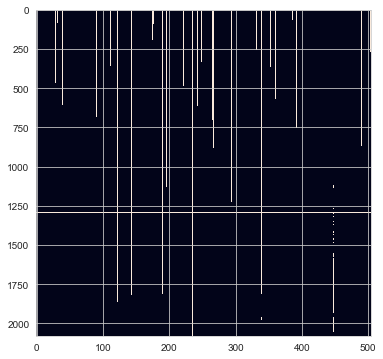

In [42]:
#### Investigate Missing Values
plt.figure(figsize = (6,6))
plt.imshow(data['Adj Close'].isna().astype(int),aspect='auto');

### Boyd's Paper drops the series that do not contain continuous observations

paper ctrl-f 'S&P' for details https://stanford.edu/~boyd/papers/pdf/cvx_portfolio.pdf 

In [88]:
P = data['Adj Close']
P = P[~P.isna().all(axis=1)] #dropping rows with all missing values
P = P.loc[:,~P.isna().any(axis=0)]
P.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,23.818647,4.826837,67.798805,50.994907,33.385769,18.250000,21.986044,44.309837,28.570000,29.164673,...,20.369633,26.864021,64.519592,33.558529,18.584305,22.358345,34.445507,50.152138,35.720001,15.257210
2012-01-04,23.629299,4.741990,69.388268,51.268970,33.499771,18.110001,21.900763,44.293118,28.280001,29.124205,...,20.235518,26.582462,64.534569,33.549038,18.470987,23.096504,34.680763,49.473404,35.450001,15.593829
2012-01-05,24.158173,5.156795,69.829826,51.838169,33.754089,18.270000,21.850374,43.447910,28.480000,29.253723,...,20.324926,26.814333,64.339516,33.577511,18.357662,22.767448,34.945400,50.059166,35.400002,16.030531
2012-01-06,24.419334,5.279352,70.153603,52.380054,33.841782,18.139999,21.652693,43.372604,28.719999,29.059444,...,20.265320,26.640434,63.859360,33.378315,18.357662,22.385023,35.198296,50.189331,35.110001,16.048729
2012-01-09,25.059198,5.392481,70.133995,52.296970,33.824242,18.209999,21.648811,43.297291,28.530001,29.626060,...,20.280226,27.220114,64.144455,33.217072,18.335001,22.473965,35.063023,50.561256,34.950001,16.267075


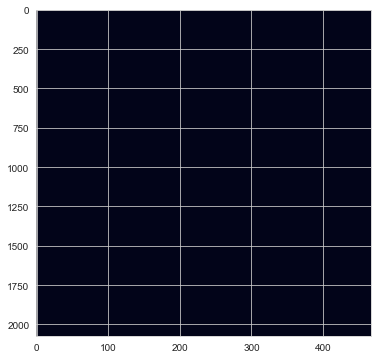

In [89]:
#### No more missing values
plt.figure(figsize = (6,6))
plt.imshow(P.isna().astype(int),aspect='auto');

### Changepoint detection:

Given a series, a window to define the changepoint, use the wasserstein hypothesis estimator to detect the change

If there is a change then we will reoptimize the portfolio, with an ambiguity parameter that is proportional to the size of the estimated change? 